In [1]:
import warnings
warnings.filterwarnings("ignore")
!pip install opendatasets --upgrade --quiet
import opendatasets as od
od.version()

'0.1.22'

In [2]:
!git clone https://github.com/KayBee8268/DL_SANet

Cloning into 'DL_SANet'...
remote: Enumerating objects: 410, done.
remote: Counting objects: 100% (268/268), done.
remote: Compressing objects: 100% (184/184), done.
remote: Total 410 (delta 92), reused 224 (delta 76), pack-reused 142
Receiving objects: 100% (410/410), 54.64 MiB | 36.02 MiB/s, done.
Resolving deltas: 100% (127/127), done.


In [3]:
!pip install torch-summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 40.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.3/269.3 kB 32.1 MB/s eta 0:00:00


In [5]:
import pandas as pd
import numpy as np

In [6]:
import scipy
import scipy.io
import cv2

from matplotlib import pyplot as plt

from scipy.ndimage import gaussian_filter

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

from PIL import Image

from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning import seed_everything

import os

In [7]:
def show(im):
    plt.figure(figsize=(7, 7))
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

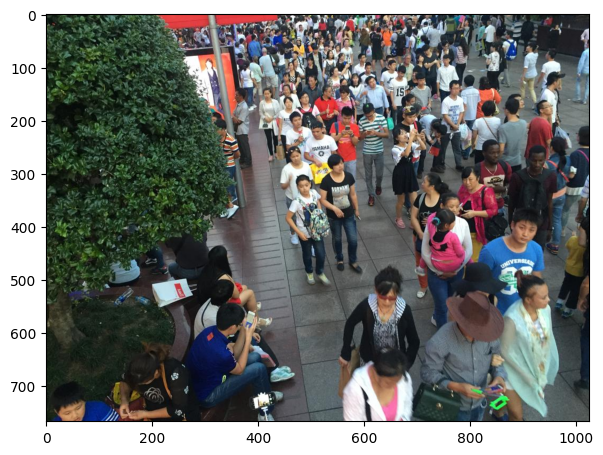

In [8]:
im = cv2.imread('/content/DL_SANet/data/ShanghaiTech/part_B/train_data/images/IMG_1.jpg', cv2.IMREAD_COLOR)
show(im)

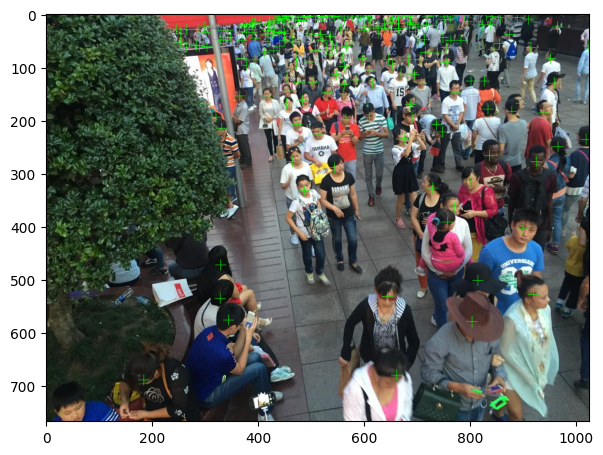

In [9]:
m = scipy.io.loadmat('/content/DL_SANet/data/ShanghaiTech/part_B/train_data/ground-truth/GT_IMG_1.mat')
ps = m['image_info'][0][0][0][0][0]

for x, y in ps:
    x = int(x)
    y = int(y)
    cv2.drawMarker(im, (x, y), (0, 255, 0))
    
show(im)

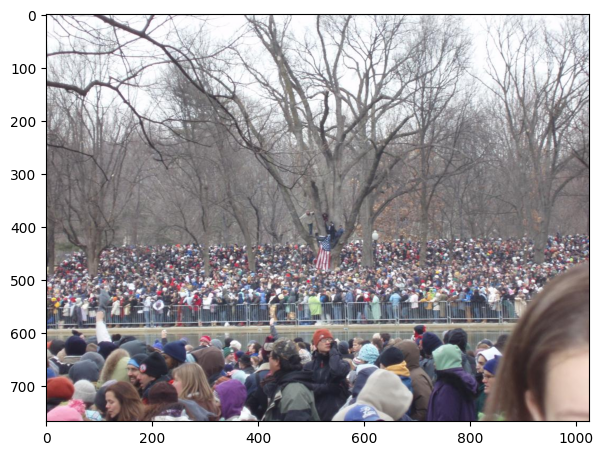

In [10]:
im = cv2.imread('/content/DL_SANet/data/ShanghaiTech/part_A/train_data/images/IMG_1.jpg', cv2.IMREAD_COLOR)
show(im)

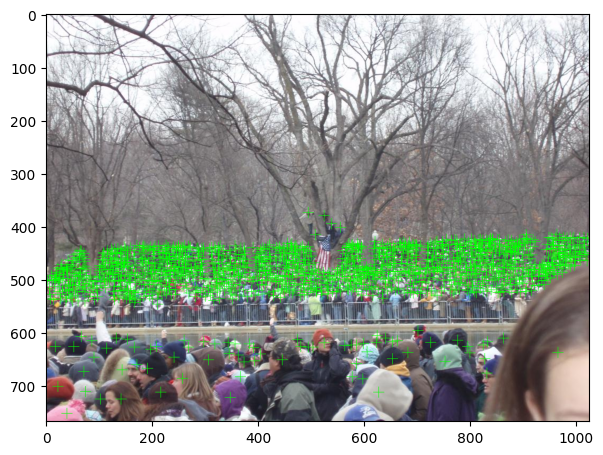

In [11]:
m = scipy.io.loadmat('/content/DL_SANet/data/ShanghaiTech/part_A/train_data/ground-truth/GT_IMG_1.mat')
ps = m['image_info'][0][0][0][0][0]

for x, y in ps:
    x = int(x)
    y = int(y)
    cv2.drawMarker(im, (x, y), (0, 255, 0))
    
show(im)

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
trainb = [p.path for p in os.scandir('/content/DL_SANet/data/ShanghaiTech/part_B/train_data/images/')]
validb = trainb[-5:]
trainb = trainb[:-5]
testb = [p.path for p in os.scandir('/content/DL_SANet/data/ShanghaiTech/part_B/test_data/images/')]

In [14]:
traina = [p.path for p in os.scandir('/content/DL_SANet/data/ShanghaiTech/part_A/train_data/images/')]
valida = traina[-5:]
traina = traina[:-5]
testa = [p.path for p in os.scandir('/content/DL_SANet/data/ShanghaiTech/part_A/test_data/images/')]

In [15]:
len(trainb), len(validb), len(testb)

(25, 5, 10)

In [16]:
len(traina), len(valida), len(testa)

(25, 5, 10)

In [17]:
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [18]:
im_size = 300

aug_train = A.Compose([
    A.RandomCrop(im_size, im_size),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(),
    A.Normalize((0.5), (0.5)),
], keypoint_params=A.KeypointParams(format='xy', angle_in_degrees=False))

aug_val = A.Compose([
    A.Resize(768, 1024),
    A.Normalize((0.5), (0.5)),
], keypoint_params=A.KeypointParams(format='xy', angle_in_degrees=False))

class MyDataset(Dataset):
    def __init__(self, files, aug):
        self.files = files
        self.aug = aug
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        fn = self.files[idx]
        
        im = cv2.imread(fn, cv2.IMREAD_COLOR)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        
        m = scipy.io.loadmat(fn.replace('images', 'ground-truth').replace('IMG', 'GT_IMG').replace('.jpg', '.mat'))
        ps = m['image_info'][0][0][0][0][0]
        
        rst = self.aug(image=im, keypoints=ps)
        im = rst['image']
        ps = rst['keypoints']
        
        dm = np.zeros((im.shape[0], im.shape[1]), dtype=np.float32)
        for x, y in ps:
            x = int(x)
            y = int(y)
            dm[y, x] = 1

        sigma = 4
        dm = gaussian_filter(dm, sigma=sigma, truncate=4*sigma)
        
        dm = cv2.resize(dm, (im.shape[1] // 4, im.shape[0] // 4), interpolation=cv2.INTER_LINEAR)
        dm *= 16
        
        im = torch.from_numpy(im)
        dm = torch.from_numpy(dm)
        
        return im, dm

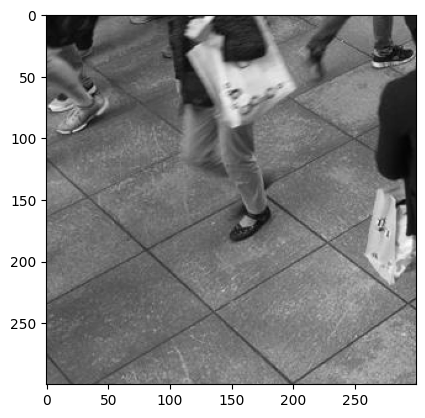

In [19]:
ds = MyDataset(trainb, aug_train)
im, dm = ds[0]
plt.imshow(im, cmap='gray')

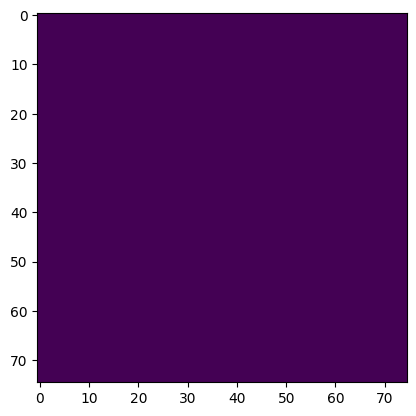

In [20]:
plt.imshow(dm)

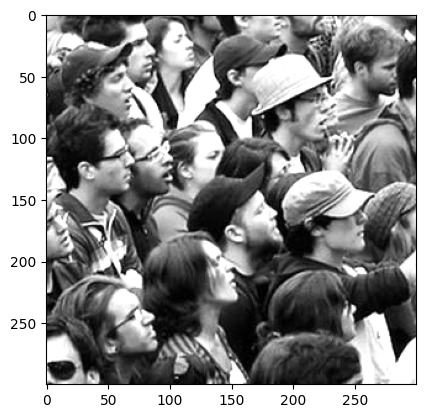

In [21]:
ds = MyDataset(traina, aug_train)
im, dm = ds[0]
plt.imshow(im, cmap='gray')

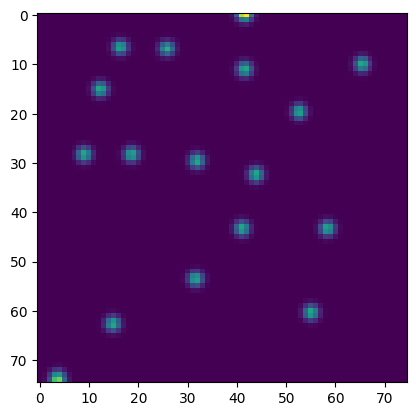

In [22]:
plt.imshow(dm)

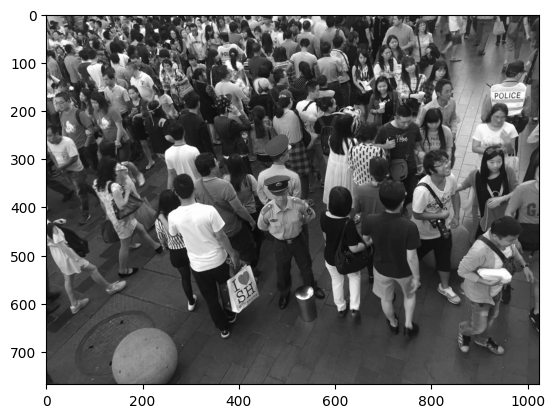

In [23]:
ds = MyDataset(validb, aug_val)
im, dm = ds[0]
plt.imshow(im, cmap='gray')

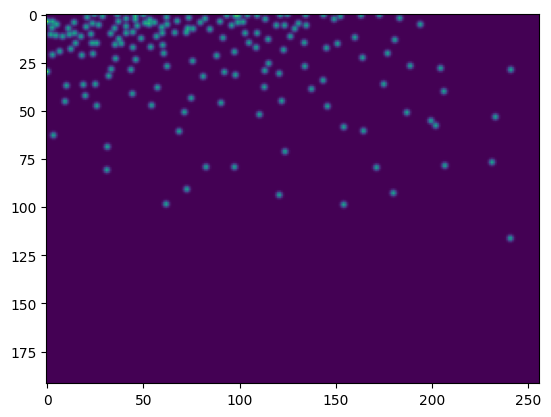

In [24]:
plt.imshow(dm)

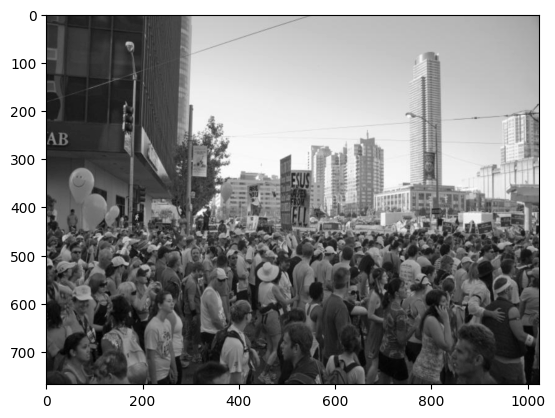

In [25]:
ds = MyDataset(valida, aug_val)
im, dm = ds[0]
plt.imshow(im, cmap='gray')

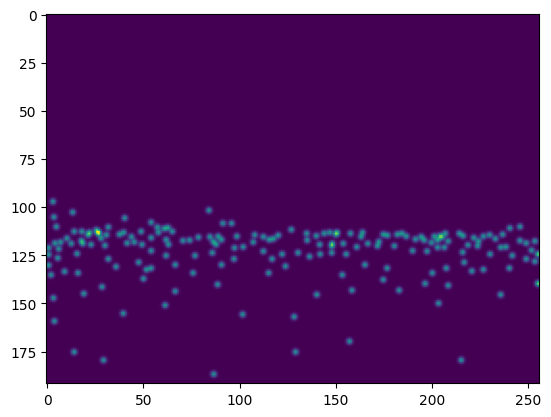

In [26]:
plt.imshow(dm)

In [27]:
dm.sum()

tensor(189.)

In [28]:
class Conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, relu=True, same_padding=False, bn=False):
        super(Conv2d, self).__init__()
        padding = int((kernel_size - 1) / 2) if same_padding else 0
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001, momentum=0, affine=True) if bn else None
        self.relu = nn.ReLU(inplace=True) if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

In [29]:
class MCNN(LightningModule):
    '''
    Multi-column CNN 
        -Implementation of Single Image Crowd Counting via Multi-column CNN (Zhang et al.)
    '''
    
    def __init__(self, lr, batch_size, max_steps, bn=False):
        super(MCNN, self).__init__()
        
        self.lr = lr
        self.save_hyperparameters()
        
        self.use = 0
        
        self.branch1 = nn.Sequential(Conv2d( 1, 16, 9, same_padding=True, bn=bn),
                                     nn.MaxPool2d(2),
                                     Conv2d(16, 32, 7, same_padding=True, bn=bn),
                                     nn.MaxPool2d(2),
                                     Conv2d(32, 16, 7, same_padding=True, bn=bn),
                                     Conv2d(16,  8, 7, same_padding=True, bn=bn))
        
        self.branch2 = nn.Sequential(Conv2d( 1, 20, 7, same_padding=True, bn=bn),
                                     nn.MaxPool2d(2),
                                     Conv2d(20, 40, 5, same_padding=True, bn=bn),
                                     nn.MaxPool2d(2),
                                     Conv2d(40, 20, 5, same_padding=True, bn=bn),
                                     Conv2d(20, 10, 5, same_padding=True, bn=bn))
        
        self.branch3 = nn.Sequential(Conv2d( 1, 24, 5, same_padding=True, bn=bn),
                                     nn.MaxPool2d(2),
                                     Conv2d(24, 48, 3, same_padding=True, bn=bn),
                                     nn.MaxPool2d(2),
                                     Conv2d(48, 24, 3, same_padding=True, bn=bn),
                                     Conv2d(24, 12, 3, same_padding=True, bn=bn))
        
        self.fuse = nn.Sequential(Conv2d( 30, 1, 1, same_padding=True, bn=bn))
        
        self.out1 = nn.Sequential(Conv2d( 8, 1, 1, same_padding=True, bn=bn))
        self.out2 = nn.Sequential(Conv2d( 10, 1, 1, same_padding=True, bn=bn))
        self.out3 = nn.Sequential(Conv2d( 12, 1, 1, same_padding=True, bn=bn))
        
        self.crit = nn.MSELoss()
        
    def forward(self, im_data):
        im_data = im_data.unsqueeze(1)
        x1 = self.branch1(im_data)
        x2 = self.branch2(im_data)
        x3 = self.branch3(im_data)
        
        
        if self.use == 0:
            x = torch.cat((x1,x2,x3),1)
            x = self.fuse(x)
        elif self.use == 1:
            x = self.out1(x1)
        elif self.use == 2:
            x = self.out2(x2)
        elif self.use == 3:
            x = self.out3(x3)
        
        return x.squeeze(1)
    
    
    def training_step(self, batch, batch_idx):
        self.train()
        x, y = batch
        
        pred = self(x)
        loss = self.crit(pred, y)
        
        pred_sum = torch.round(pred.sum(dim=(1,2))).int()
        gt_sum = torch.round(y.sum(dim=(1,2))).int()
        acc = (pred_sum == gt_sum).float().mean()
        
        mae = torch.abs(pred_sum - gt_sum).float().mean()
        
        self.log('train_loss', loss)
        self.log('train_acc', acc)
        self.log('train_mae', mae)
        
        return loss
        
    def validation_step(self, batch, batch_idx):
        with torch.no_grad():
            self.eval()
            x, y = batch
            
            pred = self(x)
            loss = self.crit(pred, y)
        
            pred_sum = torch.round(pred.sum(dim=(1,2))).int()
            gt_sum = torch.round(y.sum(dim=(1,2))).int()
            acc = (pred_sum == gt_sum).float().mean()

            mae = torch.abs(pred_sum - gt_sum).float().mean()
            
            self.log('val_loss', loss)
            self.log('val_acc', acc)
            self.log('val_mae', mae)
            
            
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=1e-4)
        
        scheduler = {
            'scheduler': torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=self.lr, total_steps=self.hparams.max_steps, pct_start=0.1, cycle_momentum=False),
            'interval': 'step',
            'frequency': 1
        }
        
        return [optimizer], [scheduler]

In [30]:
def weights_normal_init(model, dev=0.01):
    if isinstance(model, list):
        for m in model:
            weights_normal_init(m, dev)
    else:
        for n, m in model.named_modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0.0, dev)
                if m.bias is not None:
                    m.bias.data.fill_(0.0)
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0.0, dev)

In [67]:
batch_size = 4
epochs = 100
max_steps = epochs * len(trainb) // batch_size

In [68]:
train_loaderb = DataLoader(MyDataset(trainb, aug_train), batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loaderb = DataLoader(MyDataset(validb, aug_val), batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=4)
test_loaderb = DataLoader(MyDataset(testb, aug_val), batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=4)

In [69]:
train_loadera = DataLoader(MyDataset(traina, aug_train), batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loadera = DataLoader(MyDataset(valida, aug_val), batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=4)
test_loadera = DataLoader(MyDataset(testa, aug_val), batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=4)

In [70]:
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
seed_everything(42)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


42

In [62]:
bcheckpoint_cb = ModelCheckpoint(
    save_top_k=1,
    save_last=True,
    verbose=True,
    monitor='val_mae',
    mode='min',
    filename='ModelB_{epoch:02d}-{val_mae:.2f}'
)

trainerb = Trainer(max_steps=max_steps, precision=16, benchmark=True, callbacks=[bcheckpoint_cb, LearningRateMonitor()])

lr = 3e-4

modelb = MCNN(lr, batch_size, max_steps)
weights_normal_init(modelb, dev=0.01)

modelb.use = 0

trainerb.fit(modelb, train_dataloaders=train_loaderb, val_dataloaders=val_loaderb)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type       | Params
---------------------------------------
0 | branch1 | Sequential | 57.8 K
1 | branch2 | Sequential | 46.1 K
2 | branch3 | Sequential | 24.0 K
3 | fuse    | Sequential | 31    
4 | out1    | Sequential | 9     
5 | out2    | Sequential | 11    
6 | out3    | Sequential | 13    
7 | crit    | MSELoss    | 0     
---------------------------------------
127 K     Trainable params
0         Non-trainable params
127 K     Tota

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 6: 'val_mae' reached 155.60001 (best 155.60001), saving model to '/content/lightning_logs/version_5/checkpoints/ModelB_epoch=00-val_mae=155.60.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 12: 'val_mae' reached 122.60000 (best 122.60000), saving model to '/content/lightning_logs/version_5/checkpoints/ModelB_epoch=01-val_mae=122.60.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 18: 'val_mae' reached 73.00000 (best 73.00000), saving model to '/content/lightning_logs/version_5/checkpoints/ModelB_epoch=02-val_mae=73.00.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 24: 'val_mae' reached 67.20000 (best 67.20000), saving model to '/content/lightning_logs/version_5/checkpoints/ModelB_epoch=03-val_mae=67.20.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 30: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 36: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 42: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 48: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 54: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 60: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 66: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 72: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 78: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 84: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 90: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 96: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 102: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 108: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 114: 'val_mae' reached 62.80000 (best 62.80000), saving model to '/content/lightning_logs/version_5/checkpoints/ModelB_epoch=18-val_mae=62.80.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 120: 'val_mae' reached 56.80000 (best 56.80000), saving model to '/content/lightning_logs/version_5/checkpoints/ModelB_epoch=19-val_mae=56.80.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 20, global step 126: 'val_mae' reached 55.40000 (best 55.40000), saving model to '/content/lightning_logs/version_5/checkpoints/ModelB_epoch=20-val_mae=55.40.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 21, global step 132: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 22, global step 138: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 23, global step 144: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 24, global step 150: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 25, global step 156: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 26, global step 162: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 27, global step 168: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 28, global step 174: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 29, global step 180: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 30, global step 186: 'val_mae' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 31, global step 187: 'val_mae' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=187` reached.


In [100]:
!git clone https://github.com/nksrivastavaa/DL_project_files

Cloning into 'DL_project_files'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 40 (delta 15), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (40/40), 24.20 MiB | 11.80 MiB/s, done.


In [63]:
from tqdm.notebook import tqdm

In [101]:
modelb = MCNN.load_from_checkpoint('/content/DL_project_files/final_submission/ModelB_epoch=30-val_mae=27.20.ckpt')
modelb = modelb.cuda()
modelb.eval()
rst = []
gt = []
for x, y in tqdm(test_loaderb):
    with torch.no_grad():
        x = x.cuda(non_blocking=True)
        pred = torch.round(modelb(x).sum(dim=(1,2))).int().cpu().numpy()
        
    rst.append(pred)
    gt.append(y.sum(dim=(1,2)).int().numpy())
    
rst = np.concatenate(rst, axis=0)
gt = np.concatenate(gt, axis=0)

print("MAE on SHT B:", np.abs((rst - gt)).astype(np.float32).mean())
print("MSE on SHT B:", ((rst - gt) ** 2).mean())

  0%|          | 0/3 [00:00<?, ?it/s]

MAE on SHT B: 56.5
MSE on SHT B: 4749.3


In [71]:
acheckpoint_cb = ModelCheckpoint(
    save_top_k=1,
    save_last=True,
    verbose=True,
    monitor='val_mae',
    mode='min',
    filename='ModelA_{epoch:02d}-{val_mae:.2f}'
)

trainera = Trainer(max_steps=max_steps, precision=16, benchmark=True, callbacks=[acheckpoint_cb, LearningRateMonitor()])

lr = 3e-4

modela = MCNN(lr, batch_size, max_steps)
weights_normal_init(modela, dev=0.01)

modela.use = 0

trainera.fit(modela, train_dataloaders=train_loadera, val_dataloaders=val_loadera)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type       | Params
---------------------------------------
0 | branch1 | Sequential | 57.8 K
1 | branch2 | Sequential | 46.1 K
2 | branch3 | Sequential | 24.0 K
3 | fuse    | Sequential | 31    
4 | out1    | Sequential | 9     
5 | out2    | Sequential | 11    
6 | out3    | Sequential | 13    
7 | crit    | MSELoss    | 0     
---------------------------------------
127 K     Trainable params
0         Non-trainable params
127 K     Tota

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 6: 'val_mae' reached 623.79999 (best 623.79999), saving model to '/content/lightning_logs/version_7/checkpoints/ModelA_epoch=00-val_mae=623.80.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 12: 'val_mae' reached 615.20001 (best 615.20001), saving model to '/content/lightning_logs/version_7/checkpoints/ModelA_epoch=01-val_mae=615.20.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 18: 'val_mae' reached 597.59998 (best 597.59998), saving model to '/content/lightning_logs/version_7/checkpoints/ModelA_epoch=02-val_mae=597.60.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 24: 'val_mae' reached 561.20001 (best 561.20001), saving model to '/content/lightning_logs/version_7/checkpoints/ModelA_epoch=03-val_mae=561.20.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 30: 'val_mae' reached 469.39999 (best 469.39999), saving model to '/content/lightning_logs/version_7/checkpoints/ModelA_epoch=04-val_mae=469.40.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 36: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 42: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 48: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 54: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 60: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 66: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 72: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 78: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 84: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 90: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 96: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 102: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 108: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 114: 'val_mae' reached 449.60001 (best 449.60001), saving model to '/content/lightning_logs/version_7/checkpoints/ModelA_epoch=18-val_mae=449.60.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 120: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 20, global step 126: 'val_mae' reached 407.60001 (best 407.60001), saving model to '/content/lightning_logs/version_7/checkpoints/ModelA_epoch=20-val_mae=407.60.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 21, global step 132: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 22, global step 138: 'val_mae' reached 383.60001 (best 383.60001), saving model to '/content/lightning_logs/version_7/checkpoints/ModelA_epoch=22-val_mae=383.60.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 23, global step 144: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 24, global step 150: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 25, global step 156: 'val_mae' reached 376.39999 (best 376.39999), saving model to '/content/lightning_logs/version_7/checkpoints/ModelA_epoch=25-val_mae=376.40.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 26, global step 162: 'val_mae' reached 370.60001 (best 370.60001), saving model to '/content/lightning_logs/version_7/checkpoints/ModelA_epoch=26-val_mae=370.60.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 27, global step 168: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 28, global step 174: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 29, global step 180: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 30, global step 186: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 31, global step 192: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 32, global step 198: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 33, global step 204: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 34, global step 210: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 35, global step 216: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 36, global step 222: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 37, global step 228: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 38, global step 234: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 39, global step 240: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 40, global step 246: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 41, global step 252: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 42, global step 258: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 43, global step 264: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 44, global step 270: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 45, global step 276: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 46, global step 282: 'val_mae' reached 367.60001 (best 367.60001), saving model to '/content/lightning_logs/version_7/checkpoints/ModelA_epoch=46-val_mae=367.60.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 47, global step 288: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 48, global step 294: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 49, global step 300: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 50, global step 306: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 51, global step 312: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 52, global step 318: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 53, global step 324: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 54, global step 330: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 55, global step 336: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 56, global step 342: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 57, global step 348: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 58, global step 354: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 59, global step 360: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 60, global step 366: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 61, global step 372: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 62, global step 378: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 63, global step 384: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 64, global step 390: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 65, global step 396: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 66, global step 402: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 67, global step 408: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 68, global step 414: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 69, global step 420: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 70, global step 426: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 71, global step 432: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 72, global step 438: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 73, global step 444: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 74, global step 450: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 75, global step 456: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 76, global step 462: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 77, global step 468: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 78, global step 474: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 79, global step 480: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 80, global step 486: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 81, global step 492: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 82, global step 498: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 83, global step 504: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 84, global step 510: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 85, global step 516: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 86, global step 522: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 87, global step 528: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 88, global step 534: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 89, global step 540: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 90, global step 546: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 91, global step 552: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 92, global step 558: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 93, global step 564: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 94, global step 570: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 95, global step 576: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 96, global step 582: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 97, global step 588: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 98, global step 594: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 99, global step 600: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 100, global step 606: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 101, global step 612: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 102, global step 618: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 103, global step 624: 'val_mae' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 104, global step 625: 'val_mae' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=625` reached.


In [102]:
modela = MCNN.load_from_checkpoint('/content/DL_project_files/final_submission/ModelA_epoch=46-val_mae=367.60.ckpt')
modela = modela.cuda()
modela.eval()
rst = []
gt = []
for x, y in tqdm(test_loadera):
    with torch.no_grad():
        x = x.cuda(non_blocking=True)
        pred = torch.round(modela(x).sum(dim=(1,2))).int().cpu().numpy()
        
    rst.append(pred)
    gt.append(y.sum(dim=(1,2)).int().numpy())
    
rst = np.concatenate(rst, axis=0)
gt = np.concatenate(gt, axis=0)

print("MAE on SHT A:", np.abs((rst - gt)).astype(np.float32).mean())
print("MSE on SHT A:", ((rst - gt) ** 2).mean())

  0%|          | 0/3 [00:00<?, ?it/s]

MAE on SHT A: 410.3
MSE on SHT A: 209031.5


In [79]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

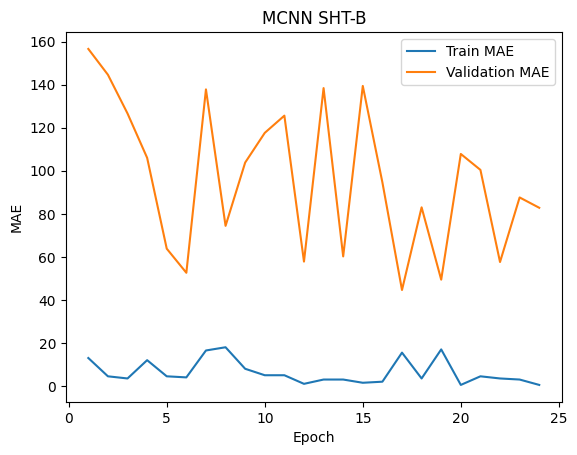

In [103]:
events_file = "/content/DL_project_files/final_submission/events.out.tfevents.1682355201.968bb0c92206.982.1"
event_acc = EventAccumulator(events_file)
event_acc.Reload()

epoch_list = []
train_mae_values = []
epno = 1

for scalar in event_acc.Scalars('train_mae'):
    train_mae_values.append(scalar.value)
    epoch_list.append(epno)
    epno += 1

val_mae_values = []

for scalar in event_acc.Scalars('val_mae'):
    val_mae_values.append(scalar.value)

actlen = min(len(train_mae_values), len(val_mae_values)) - 1

plt.plot(epoch_list[0:actlen], train_mae_values[0:actlen], label='Train MAE')
plt.plot(epoch_list[0:actlen], val_mae_values[0:actlen], label='Validation MAE')
plt.title("MCNN SHT-B")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.show()

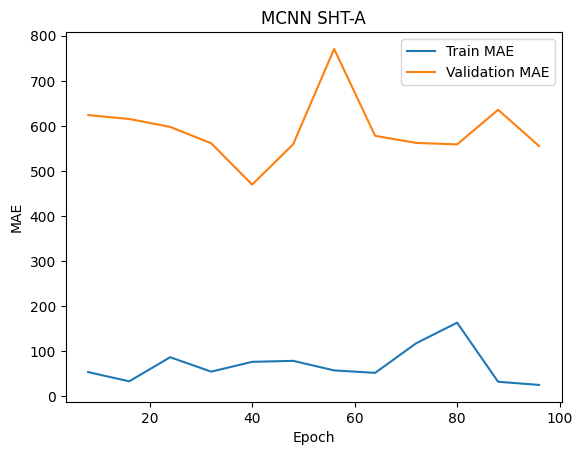

In [104]:
events_file = "/content/DL_project_files/final_submission/events.out.tfevents.1682356308.968bb0c92206.982.7"
event_acc = EventAccumulator(events_file)
event_acc.Reload()

epoch_list = []
train_mae_values = []
epno = 8

for scalar in event_acc.Scalars('train_mae'):
    train_mae_values.append(scalar.value)
    epoch_list.append(epno)
    epno += 8

val_mae_values = []

for scalar in event_acc.Scalars('val_mae'):
    val_mae_values.append(scalar.value)

actlen = min(len(train_mae_values), len(val_mae_values))

plt.plot(epoch_list[0:actlen], train_mae_values[0:actlen], label='Train MAE')
plt.plot(epoch_list[0:actlen], val_mae_values[0:actlen], label='Validation MAE')
plt.title("MCNN SHT-A")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.show()